In [6]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [7]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')



100%|██████████| 4.16M/4.16M [00:00<00:00, 43.5MB/s]

Extracting files...


## **Data Dictionary**

|Name|Description|Units|Type|
|----|-----------|-----|----|
|airline|airline name|none|category|
|airline|airline name|none|category|

In [8]:
# 1.1 Read from source and get basic info
df_raw.info(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [9]:
# 1.2 Get a sample
df_raw.sample(5)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
32273,32273,Air_India,AI-803,Delhi,Early_Morning,one,Night,Hyderabad,Economy,14.08,28,5530
36331,36331,Indigo,6E-5175,Delhi,Morning,one,Afternoon,Chennai,Economy,6.67,10,7950
96614,96614,GO_FIRST,G8-385,Bangalore,Early_Morning,zero,Early_Morning,Mumbai,Economy,1.58,17,2201
22014,22014,GO_FIRST,G8-153,Delhi,Morning,one,Afternoon,Kolkata,Economy,4.67,13,5954
75685,75685,Air_India,AI-651,Mumbai,Morning,one,Evening,Hyderabad,Economy,7.75,38,5977


In [28]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    #.astype({'target': np.float16})
    .iloc[:,1:]
)
df_interim



,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,target
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [29]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   target            300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [27]:
df.sample(10)

/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,target,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
118380,4672.0,Vistara,UK-852,Bangalore,Morning,one,Morning,Chennai,Economy,23.33,35
46011,8752.0,AirAsia,I5-471,Mumbai,Night,one,Morning,Delhi,Economy,11.33,17
17453,4536.0,Air_India,AI-544,Delhi,Evening,one,Night,Bangalore,Economy,5.00,37
16073,4040.0,Air_India,AI-839,Delhi,Night,one,Afternoon,Bangalore,Economy,17.50,31
260412,59104.0,Vistara,UK-867,Bangalore,Afternoon,two_or_more,Evening,Chennai,Business,31.17,33
261344,53664.0,Air_India,AI-765,Kolkata,Night,one,Afternoon,Delhi,Business,16.25,3
214750,57024.0,Vistara,UK-943,Delhi,Early_Morning,one,Evening,Bangalore,Business,10.25,35
133176,4500.0,Indigo,6E-6087,Kolkata,Evening,zero,Night,Mumbai,Economy,2.83,36
161348,4264.0,Vistara,UK-870,Hyderabad,Night,one,Afternoon,Mumbai,Economy,17.42,22
148404,13016.0,Vistara,UK-772,Kolkata,Morning,one,Morning,Chennai,Economy,22.42,6


In [22]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 195166 to 240112
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   target            230273 non-null  float16
 1   airline           240122 non-null  object 
 2   flight            240122 non-null  object 
 3   source_city       240122 non-null  object 
 4   departure_time    240122 non-null  object 
 5   stops             240122 non-null  object 
 6   arrival_time      240122 non-null  object 
 7   destination_city  240122 non-null  object 
 8   class             240122 non-null  object 
 9   duration          240122 non-null  float64
 10  days_left         240122 non-null  int64  
dtypes: float16(1), float64(1), int64(1), object(8)
memory usage: 20.6+ MB


In [26]:
print(df_train['target'].isnull().sum())

9849


In [23]:
display(df_train.describe(include=object).T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
flight,240122,1559,UK-706,2582
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


,count,mean,std,min,25%,50%,75%,max
target,230273.0,NaN,0.000000,1105.00,4672.00,7056.00,35552.00,65504.00
duration,240122.0,12.227363,7.189270,0.83,6.83,11.25,16.17,49.83
days_left,240122.0,26.001533,13.558442,1.00,15.00,26.00,38.00,49.00


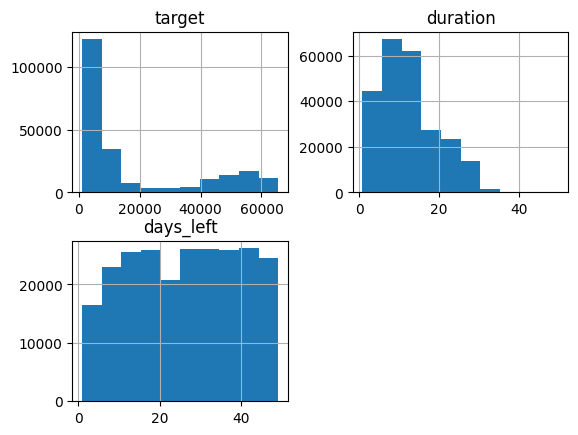

In [20]:
df_train.hist()
plt.show()